# Evaluierung des SIFT Detektors

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
from typing import List, Tuple, Dict, Any
import eval_repeatability as er
import config_repeatability as cfg_rep
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
%matplotlib inline

### Lade Daten

In [2]:
detector_name='sift'

In [3]:
with open('outputs/repeatability_{}.pkl'.format(detector_name), 'rb') as dst:
    data = pickle.load(dst, encoding='utf-8')
    

In [4]:
config = cfg_rep.get_config(None)

### Hilfsfunktionen

In [5]:
def smart_scale(image: np.array, size: int, prevent_upscaling: bool=False) -> np.array:
    """Set the max size for the larger dimension of an image and scale the
    image accordingly. If `size` and the dimension of the image already
    correspond, return the image
    If prevent_upscaling is set, return image if size is larger then the largest
    dimension of the image.

    Arguments:
        image {np.array} -- The image to be rescaled.
        size {int} -- Maximal size of the larger dimension of the image

    Returns:
        np.array -- Resized image, such that it's larger dimension is equal to
        `size`.
    """
    max_dim = np.max(image.shape[:2])   # max dimension of image
    interpolation = cv2.INTER_AREA      # Select interpolation algorithm
    scaling = size / max_dim            # Get scaling factor

    # If the largest iamge dimension already corresponds to the wanted size,
    # just return the image
    if max_dim == size:
        return image

    if max_dim < size:
        interpolation = cv2.INTER_LINEAR # for upscaling

    return cv2.resize(image, None, fx=scaling, fy=scaling,
        interpolation=interpolation)

### Plot Funktionen

In [6]:
def plot_num_keypoints_per_image(ax, data_set, detector_name, set_name):
    num_kpts_per_image = data_set['num_kpts_per_image']
    avg = data_set['num_kpts_per_image_avg']
    std = data_set['num_kpts_per_image_std']
    
    ax.axhline(y=avg+std, color='orange', linestyle=':', label='sigma +')
    ax.axhline(y=avg, color='red', label='mean {}'.format(avg))
    ax.axhline(y=avg-std, color='orange', linestyle=':', label='sigma -')
    ax.bar(np.arange(len(num_kpts_per_image)), num_kpts_per_image);
    ax.set_title('{} - {}'.format(set_name, detector_name))
    ax.set_xlabel('Das i-te Bild');
    ax.set_ylabel('Anzahl gefundener Keypunkte in Bild i');
    ax.legend();
    return ax

In [7]:
def plot_num_repeatable_keypoints(ax, data_set, detector_name, collection_name, set_name):
    epsilons = list(data_set['epsilon'].keys())
    for eps in epsilons:
        y = data_set['epsilon'][eps]['cum_repeatable_kpts']
        y = y / y[0]
        x = len(y)
    
        ax.plot(np.arange(len(y)), y, label='Epsilon={}'.format(eps))
    ax.set_title('{} - {}: Wiederholbarkeit für Epsilon'.format(detector_name, set_name))
    ax.set_xlabel('Anzahl Bilder')
    ax.set_ylabel('Prozent wiederholbare Keypunkte')
    ax.legend();
    return ax

In [8]:
def plot_repeatable_kpts_in_set(ax, data_set, model_name, collection_name, set_name, epsilon, config):
    
    # TODO: model_name, detector_name Bedeutung unklar/vertauscht
    detector_name = [x for x in config['detector_names'] if model_name == x.lower()][0]
    image_names = er.get_image_names(collection_name, set_name, config)
    kpts_files = er.get_keypoint_files(model_name, detector_name, collection_name,
        set_name, image_names, config) 
    
    kpts_idx = data_set['epsilon'][epsilon]['idx_repeatable_kpts']
    kpts_all = er.load_kpts_csv_file(kpts_files[0]).values
    kpts_rep = er.load_kpts_csv_file(kpts_files[0]).iloc[kpts_idx].values
    
    img_name = data_set['image_names'][0]
    img_path = os.path.join(config['images_dir'], collection_name, set_name, img_name + '.png')
    img = cv2.imread(img_path)
    img = smart_scale(img, int(config['max_size']))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ax.imshow(img)
    ax.plot(kpts_all[:, 0], kpts_all[:, 1], 'xb', alpha=0.3)
    ax.plot(kpts_rep[:, 0], kpts_rep[:, 1], 'xr', alpha=0.5)
    
    ax.set_title('{}, {}: Wiederholbare Keypunkte für Epsilon {}'.format(detector_name, set_name, epsilon))
    return ax


In [9]:
def plot_metrics(data, collection_name: str, set_name: str, detector_name: str, config: Dict):
    plt.rcParams['figure.figsize'] = [16, 12]
    data_set = data[collection_name][set_name]

    fig, axes = plt.subplots(nrows=2, ncols=1)
    axes[0] = plot_num_keypoints_per_image(axes[0], data_set, detector_name, set_name)
    axes[1] = plot_num_repeatable_keypoints(axes[1], data_set, detector_name, collection_name, set_name)
    
    fig2, axes2 = plt.subplots(nrows=1, ncols=1)
    axes2 = plot_repeatable_kpts_in_set(axes2, data_set, detector_name, collection_name, set_name, 10, config)
    
    plt.show()

### Erklärung:
- Der erste Graph zeigt die **Anzahl der gefundenen Keypunkte pro Bild** innerhalb eines Sets an. Die rote Linie ist der Durchschnitt an gefundenen Keypunkten über allen Bildern. Die gelbe Linie ist der Bereich der Standardabweichung.
- **Prozentualer Anteil an Keypunkten, die **bis zum i-ten Bild **wiederholbar sind**, das heißt in allen Bildern bis zum zum i-ten Bild gefunden wurden. Die maximale Distanz der Positionen eines Keypunktpaares darf $\epsilon$ Pixel nicht überschreiten.
- Der dritte Subplot zeigt alle gefundenen Keypunkte im ersten Bild eines Sets in blau, sowie die über alle Bilder hinweg wiederholbaren Keypunkte in rot.

### Kollektion: Webcam

In [10]:
collection_name='webcam'

### Set: Chamonix

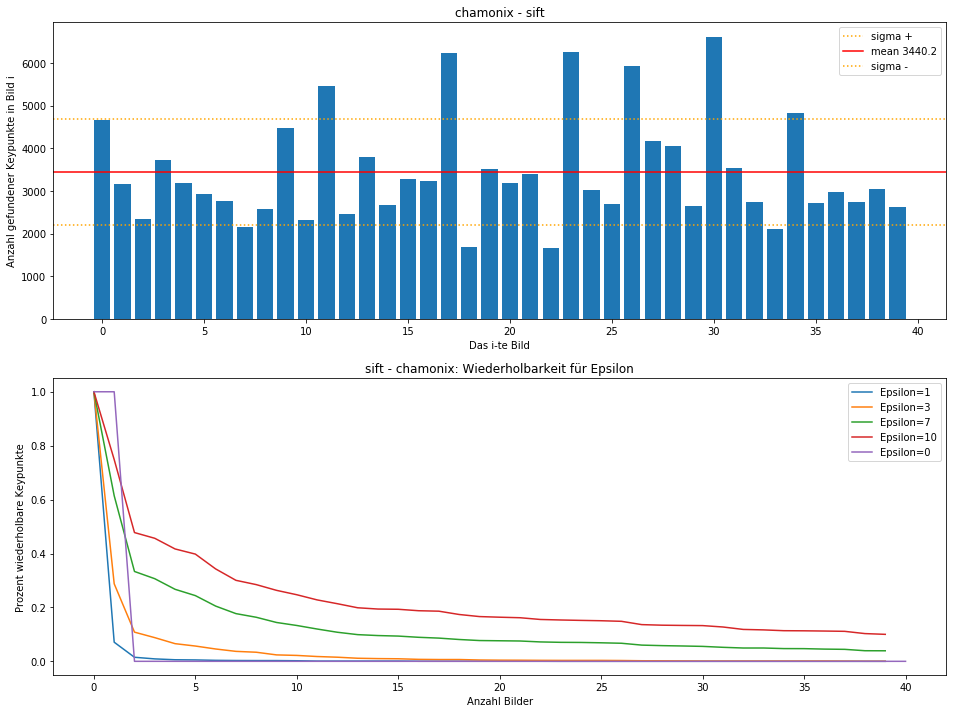

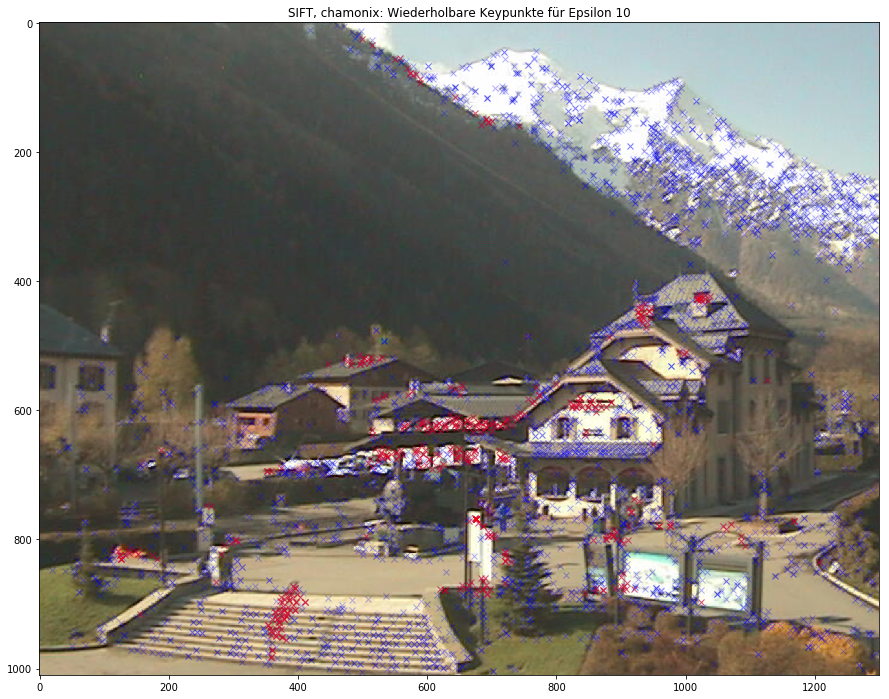

In [11]:
set_name = 'chamonix'
plot_metrics(data, collection_name, set_name, detector_name, config)

### Set Courbevoie

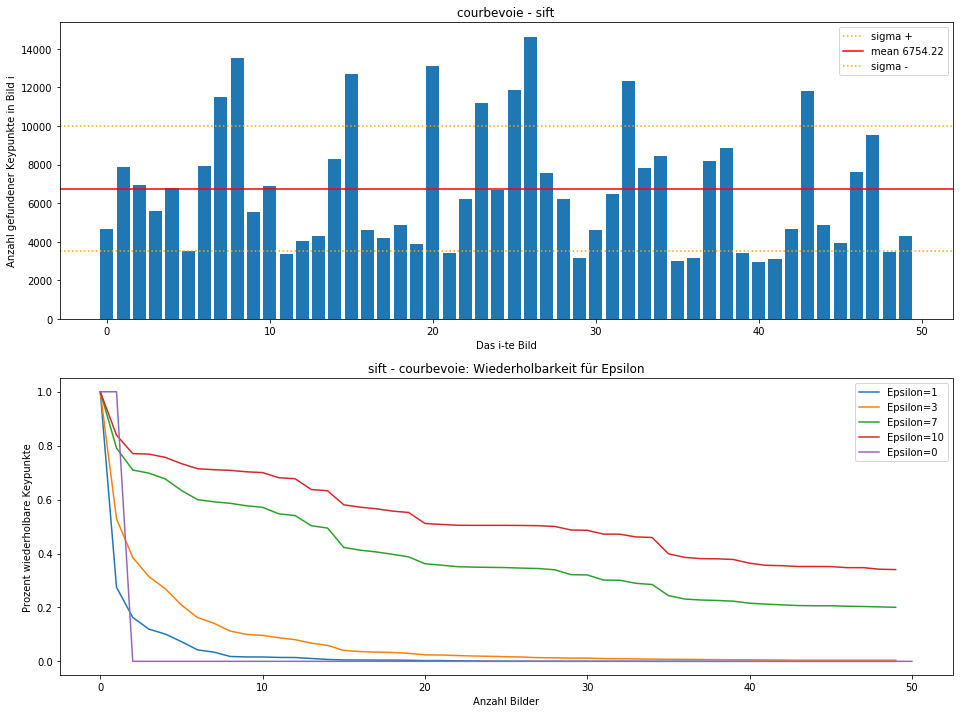

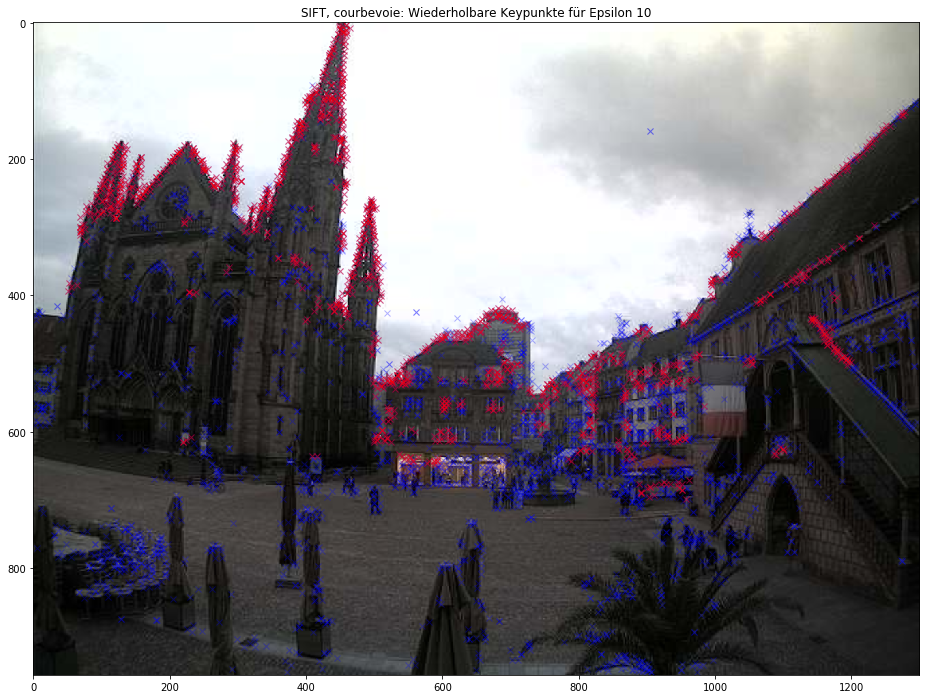

In [12]:
set_name='courbevoie'
plot_metrics(data, collection_name, set_name, detector_name, config)

### Set Frankfurt

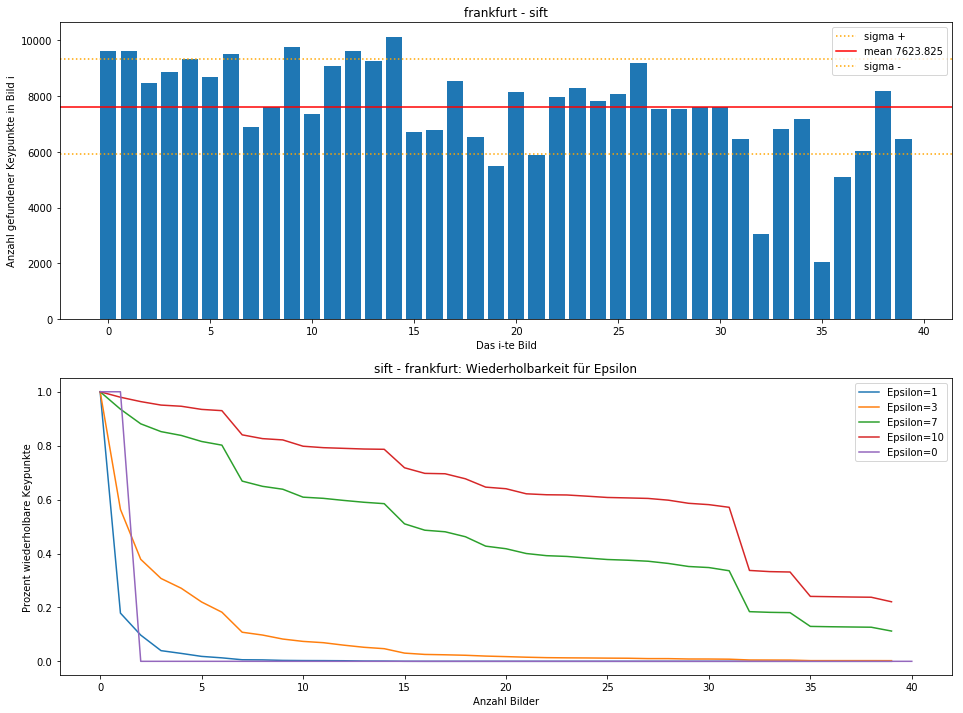

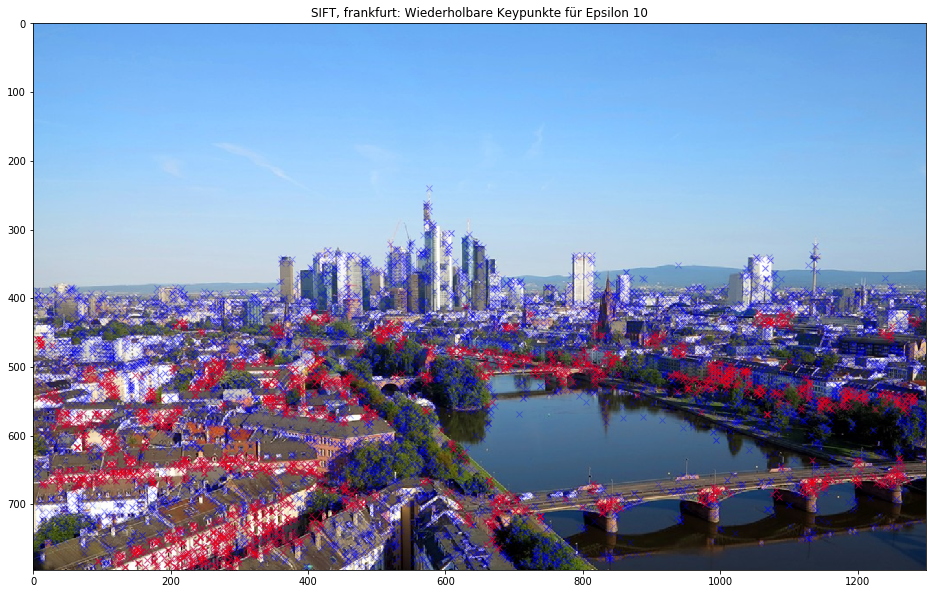

In [13]:
set_name='frankfurt'
plot_metrics(data, collection_name, set_name, detector_name, config)

### Set Mexico

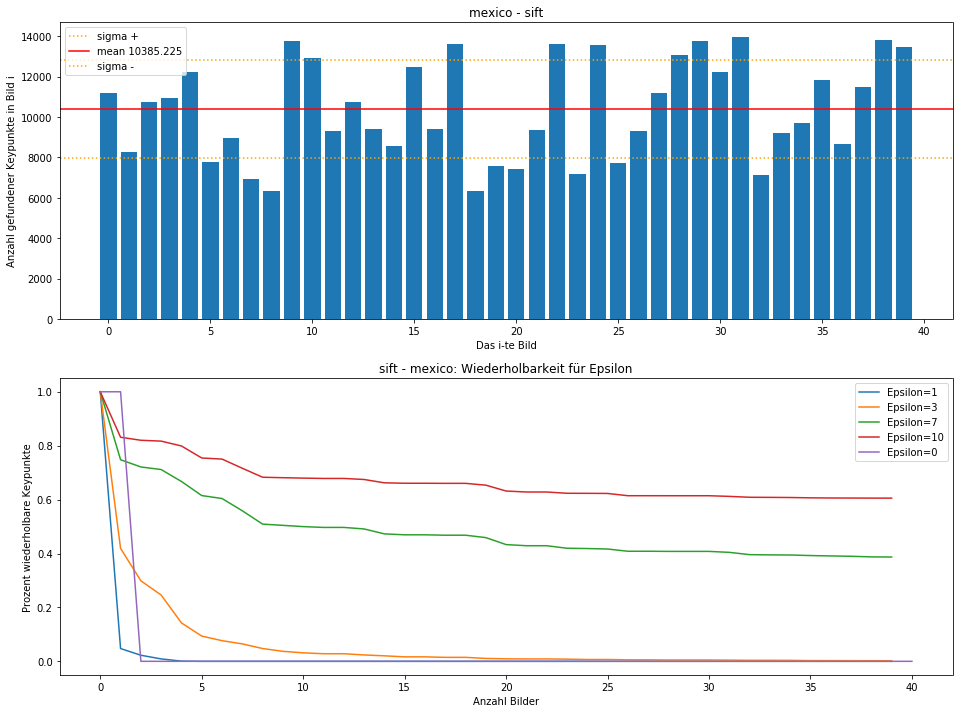

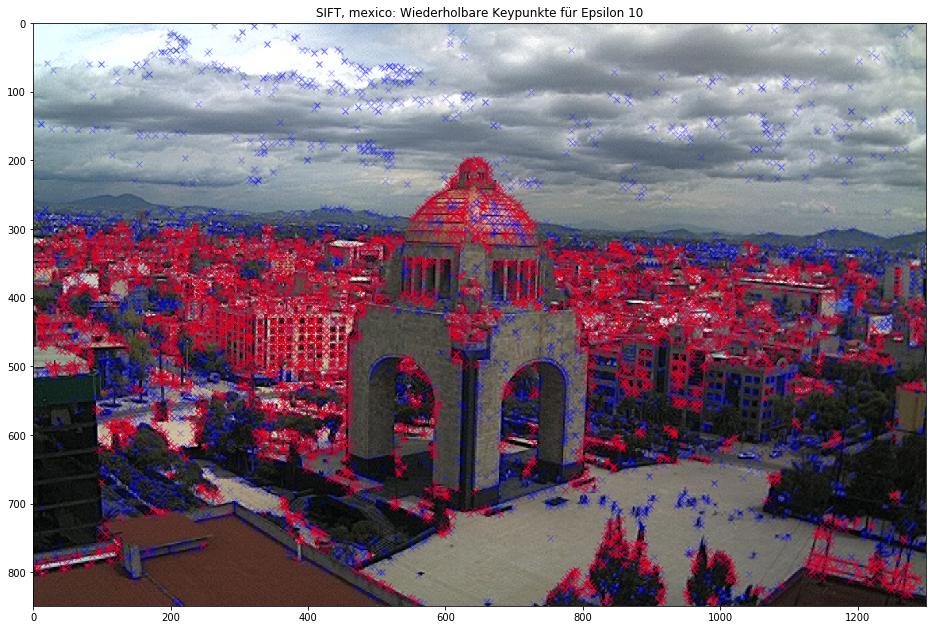

In [14]:
set_name='mexico'
plot_metrics(data, collection_name, set_name, detector_name, config)

### Set Panorama

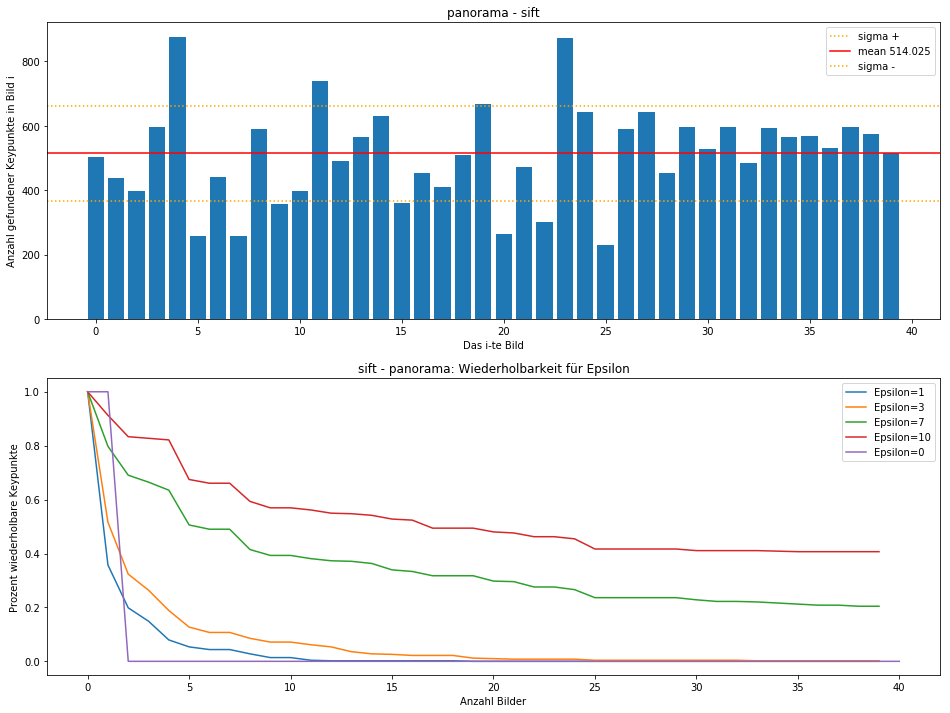

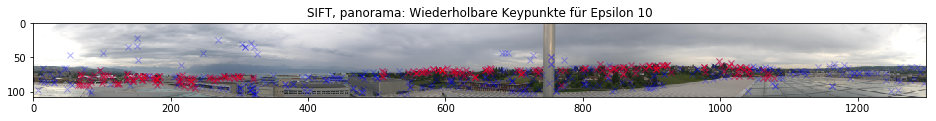

In [15]:
set_name='panorama'
plot_metrics(data, collection_name, set_name, detector_name, config)

### Set StLouis

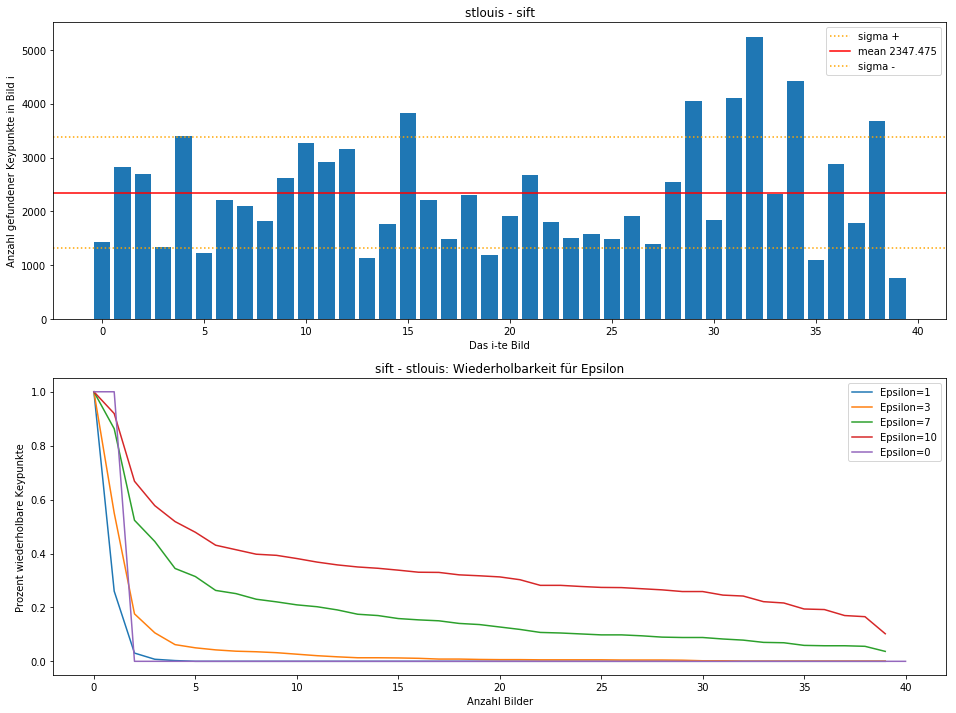

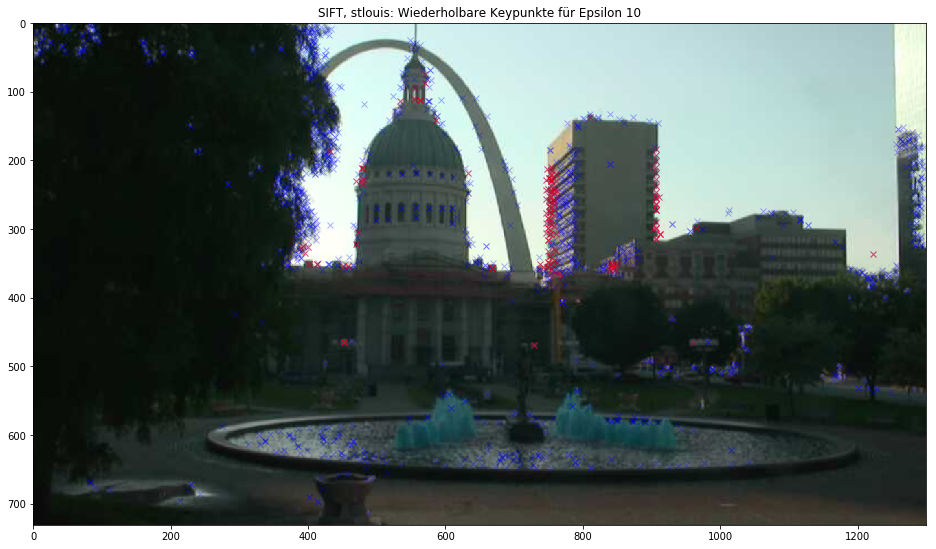

In [16]:
set_name='stlouis'
plot_metrics(data, collection_name, set_name, detector_name, config)